<a href="https://colab.research.google.com/github/PerceptualScience/DeepForestry/blob/master/Copy_of_Deep_learning_for_Malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
# Get the data
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-07-04 19:04:23--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  12.4MB/s    in 46s     

2019-07-04 19:05:11 (7.35 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
!ls

cell_images.zip  data  models


In [ ]:
!pwd

/content


In [ ]:
!unzip cell_images.zip

Archive:  cell_images.zip
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extr

In [ ]:
!ls

cell_images  cell_images.zip  data  models


### Only a few imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

In [ ]:
# Data directory structure
!tree --dirsfirst --filelimit 10 /content/cell_images/

/bin/bash: tree: command not found


In [ ]:
# Transformation values taken from https://bit.ly/2Wj13Nt
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20.,max_warp=0.0, max_zoom=0.05)
len(tfms)

2

### Looking at a few single samples

(Image (3, 64, 64), Category Parasitized)


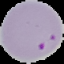

In [ ]:
print(data.train_ds[10])
data.valid_ds[10][0]

(Image (3, 64, 64), Category Uninfected)


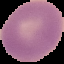

In [ ]:
print(data.valid_ds[0])
data.valid_ds[0][0]

### A brief look at the important details of the data

In [ ]:
data.label_list

LabelLists;

Train: LabelList (24803 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Parasitized,Parasitized,Parasitized,Parasitized,Parasitized
Path: /content/cell_images;

Valid: LabelList (2755 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Uninfected,Uninfected,Parasitized,Parasitized,Uninfected
Path: /content/cell_images;

Test: None

In [ ]:
# Training in mixed precision policy + 1cycle policy: https://docs.fast.ai/basic_train.html#fit_one_cycle
learn = unet_learner(data, models.resnet50, metrics=[accuracy])
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


ValueError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


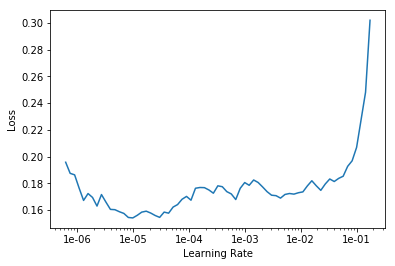

In [ ]:
# Finding a good learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Training the network for a bit more
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.160740,0.129822,0.954991,01:33
1,0.160141,0.120498,0.955717,01:34
2,0.134196,0.107607,0.961887,01:34
3,0.114827,0.101471,0.965154,01:33
4,0.106451,0.093985,0.964791,01:34


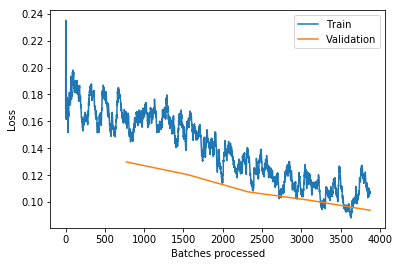

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# Training a bit more but this time in a little bit different way: no different learning rate in the last layers
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.093871,0.092714,0.967332,01:32
1,0.103151,0.093552,0.963702,01:33
2,0.105556,0.090999,0.965517,01:33
3,0.097703,0.089665,0.966606,01:33
4,0.092047,0.090053,0.965880,01:33


In [ ]:
learn.save('Stage-1-rn34')

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=64, bs=32).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy]).to_fp16()
# Reusing the weights from our previously saved model
learn.load('Stage-1-rn34')
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.099417,0.082593,0.971874,01:24


In [ ]:
# Save and export the model
learn.save('Stage-2-rn34-80_20')
learn.export('Malaria-Detection-Model.pkl')

In [ ]:
# Validation loss and accuracy
learn.validate(learn.data.valid_dl)

[0.08259339, tensor(0.9719)]

In [ ]:
# Training loss and accuracy
learn.validate(learn.data.train_dl)

[0.09235849, tensor(0.9669)]

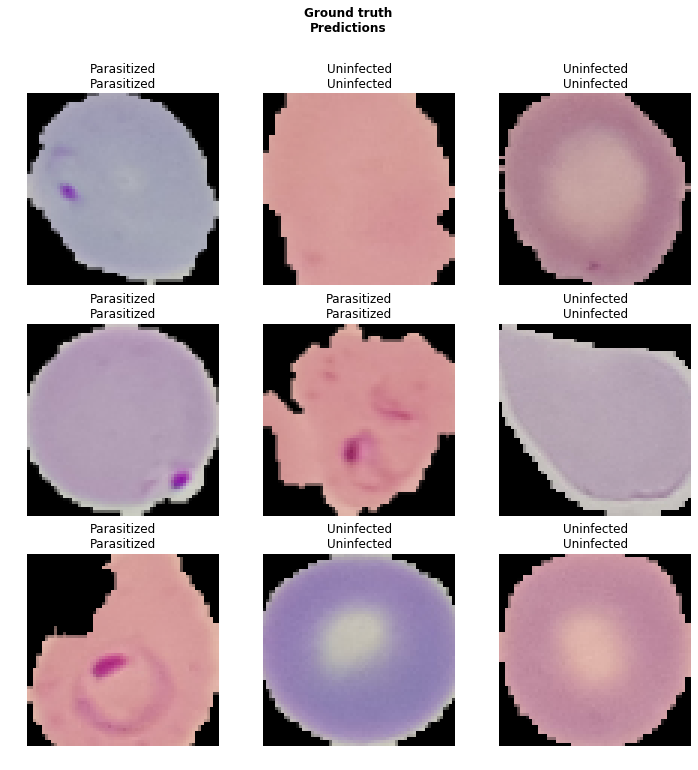

In [ ]:
learn.show_results(ds_type=DatasetType.Valid, rows=3)

In [ ]:
# Getting the prediction label of single image (from the validation set)
str(learn.predict(learn.data.valid_ds[0][0])[0])

'Parasitized'

'Parasitized'

In [ ]:
# Getting the ground truth from a single image (of validation set)
str(learn.data.valid_ds[0]).split('), ', 1)[1].replace('Category ', '').replace(')', '')

'Parasitized'

'Parasitized'

In [ ]:
ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

In [ ]:
pred_labels[:5], ground_truth[:5]

(['Parasitized', 'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized'],
 ['Parasitized', 'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized'])

(['Parasitized', 'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized'],
 ['Parasitized', 'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized'])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2751
  Uninfected       0.97      0.98      0.97      2760

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511

              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2751
  Uninfected       0.97      0.98      0.97      2760

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



Here's Adrian's classification report: 

![](https://i.ibb.co/LtcxBVr/Capture-1.png)

As we can see, our model has got a better **recall**. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

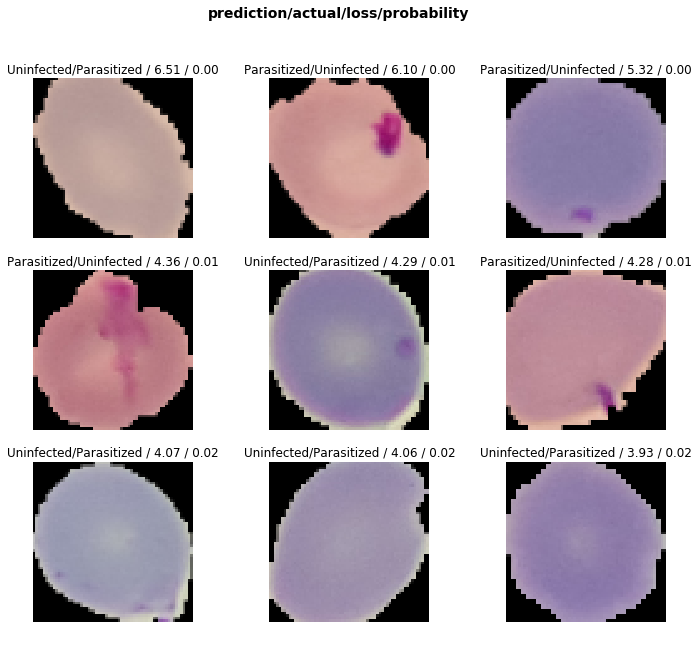

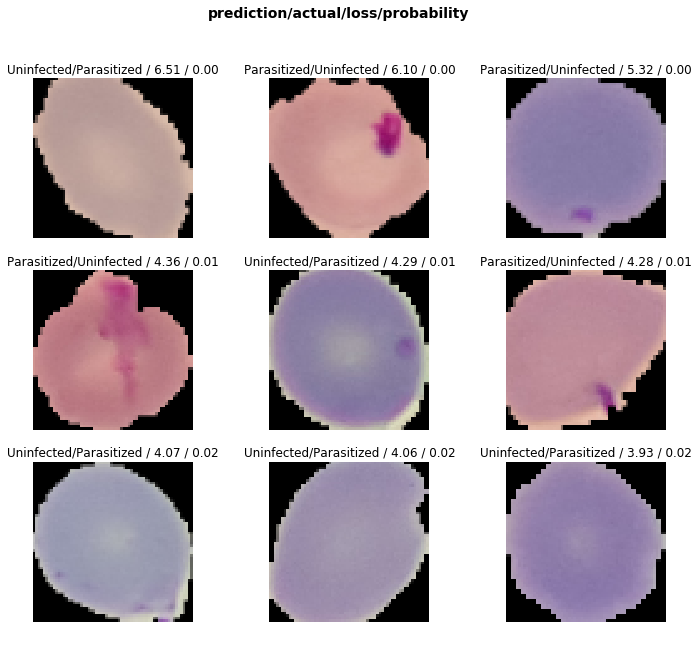

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)